#Dota2胜利结果预测
组员： 
- 郑毽 315010
- 温力成 3150104417


#前序准备工作

导入相关库

In [0]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm

从Google Drive中读入文件

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file  
#Get origin file
downloaded = drive.CreateFile({'id':'1yFlOzaHc5QHyBhZ9Jd3uhr2lWy4s0ho0'}) # Origin file ID
downloaded.GetContentFile('features.csv')  
#Get test file 
downloaded = drive.CreateFile({'id':'1_S2EjH9CHWUtCsDa58gWfWu_YnTUkAwM'}) # test file ID
downloaded.GetContentFile('features_test.csv')  

#3. Read file as panda dataframe
import pandas as pd
dota_test_features = pd.read_csv('features_test.csv')
dota_features = pd.read_csv('features.csv')

导入文件中的data

In [0]:
def preprocess_features(dota_features):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = dota_features[
    [ "r1_xp",
      "r1_gold",
      "r1_kills",
      "r1_deaths",
      "r1_lh",
      "r2_xp",
      "r2_gold",
      "r2_kills",
      "r2_deaths",
      "r2_lh",
      "r3_xp",
      "r3_gold",
      "r3_kills",
      "r3_deaths",
      "r3_lh",
      "r4_xp",
      "r4_gold",
      "r4_kills",
      "r4_deaths",
      "r4_lh",
      "r5_xp",
      "r5_gold",
      "r5_kills",
      "r5_deaths",
      "r5_lh",
      "d1_xp",
      "d1_gold",
      "d1_kills",
      "d1_deaths",
      "d1_lh",
      "d2_xp",
      "d2_gold",
      "d2_kills",
      "d2_deaths",
      "d2_lh",
      "d3_xp",
      "d3_gold",
      "d3_kills",
      "d3_deaths",
      "d3_lh",
      "d4_xp",
      "d4_gold",
      "d4_kills",
      "d4_deaths",
      "d4_lh",
      "d5_xp",
      "d5_gold",
      "d5_kills",
      "d5_deaths",
      "d5_lh",
    "dire_ward_observer_count",
    "dire_boots_count",
    "dire_ward_sentry_count",
     "radiant_boots_count",
     "radiant_ward_observer_count",
     "radiant_ward_sentry_count"
    ]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  #processed_features["first_blood"] =  dota_features["first_blood_team"]==1
  #processed_features["hero1"] = (
  #  dota_features["r1_level"] +100)
  return processed_features


def preprocess_targets(dota_features):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["radiant_win"] = (
    dota_features["radiant_win"] *1 )
  return output_targets


以下我们选取若干个数据作为训练集（此处以10000个为例）

In [109]:
training_examples = preprocess_features(dota_features.head(10000))
training_examples.describe()


,r1_xp,r1_gold,r1_kills,r1_deaths,r1_lh,r2_xp,r2_gold,r2_kills,r2_deaths,r2_lh,...,d5_gold,d5_kills,d5_deaths,d5_lh,dire_ward_observer_count,dire_boots_count,dire_ward_sentry_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1210.906700,1121.842300,0.331400,0.35330,11.166800,1190.033800,1101.36090,0.333700,0.341800,10.770300,...,1099.554400,0.349700,0.321400,10.585200,2.389400,3.34830,0.570900,3.296300,2.369100,0.596800
std,586.565483,455.066721,0.653924,0.62938,9.322471,576.928588,457.74468,0.646054,0.617261,9.384218,...,458.862079,0.673242,0.595934,9.350705,0.785003,1.16255,0.666346,1.165265,0.796448,0.719918
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,718.000000,716.000000,0.000000,0.00000,2.000000,714.000000,697.00000,0.000000,0.000000,2.000000,...,699.000000,0.000000,0.000000,2.000000,2.000000,3.00000,0.000000,3.000000,2.000000,0.000000
50%,1122.000000,1070.000000,0.000000,0.00000,10.000000,1086.000000,1035.00000,0.000000,0.000000,9.000000,...,1025.000000,0.000000,0.000000,9.000000,2.000000,3.00000,0.000000,3.000000,2.000000,1.000000
75%,1706.000000,1461.250000,1.000000,1.00000,19.000000,1677.000000,1448.25000,1.000000,1.000000,19.000000,...,1437.000000,1.000000,1.000000,18.000000,3.000000,4.00000,1.000000,4.000000,3.000000,1.000000
max,2965.000000,3068.000000,7.000000,5.00000,47.000000,3157.000000,2915.00000,5.000000,5.000000,40.000000,...,3301.000000,7.000000,4.000000,41.000000,6.000000,8.00000,5.000000,8.000000,7.000000,25.000000


In [110]:
training_targets = preprocess_targets(dota_features.head(10000))
training_targets.describe()

,radiant_win
count,10000.000000
mean,0.509700
std,0.499931
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


格式转化

In [168]:
origin_features=np.array(training_examples)
origin_targets=np.array(training_targets)
origin_targets=np.column_stack((origin_targets,-(origin_targets-1)))
X, X_test, Y, Y_test = train_test_split(origin_features, origin_targets)
print np.shape(X)

(7500, 56)


#SVM分类器
支持向量机（support vector machine），故一般简称SVM，它是一种二类分类模型，其基本模型定义为特征空间上的间隔最大的线性分类器。其学习策略便是间隔最大化，最终可转化为一个凸二次规划问题的求解。

- 代码使用scikit-learn自带的SVM模块的SVC函数。
- 内核选择为rbf核函数，决策函数设置为ovo，伽马值默认为1/2



In [124]:
#clf = svm.SVC(C=0.1, kernel='linear', decision_function_shape='ovr')
clf = svm.SVC(C=0.51, kernel='rbf', gamma=0.5, decision_function_shape='ovo')
#clf = svm.SVC()
clf.fit(X, Y.ravel())

SVC(C=0.51, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [125]:
np.set_printoptions(threshold='nan')
print clf.score(X, Y)  # 精度
y_hat = clf.predict(X)
print clf.score(X_test, Y_test)
y_hat = clf.predict(X_test)

0.9994666666666666
0.5144


惩罚力度C=0.50时，训练集精度0.5084 测试集精度0.5144

惩罚力度C=0.51时，训练集精度0.9994 测试集精度0.5144

效果并不明显


#随机森林算法

决策树算法在训练参数选择不是很合理的情况下，会产生过拟合的现象，导致泛化能力变弱。

随机森林采用多个决策树的投票机制来改善决策树，我们假设随机森林使用了m棵决策树，那么就需要产生m个一定数量的样本集来训练每一棵树。

随机森林的生成方法：
1. 从样本集中通过重采样的方式产生n个样本
2. 假设样本特征数目为a，对n个样本选择a中的k个特征，用建立决策树的方式获得最佳分割点
3. 重复m次，产生m棵决策树
4. 多数投票机制来进行预测


In [153]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=3,random_state=0)
scores = cross_val_score(clf, X, Y.ravel())
scores.mean()       

0.566798460885087

首先优化参数n_estimators，即树木总数。


n_estimate: 10
n_estimate: 20
n_estimate: 30
n_estimate: 40
n_estimate: 50
n_estimate: 60
n_estimate: 70
n_estimate: 80
n_estimate: 90
n_estimate: 100
n_estimate: 110
n_estimate: 120
n_estimate: 130
n_estimate: 140
n_estimate: 150
Optimization Complete!


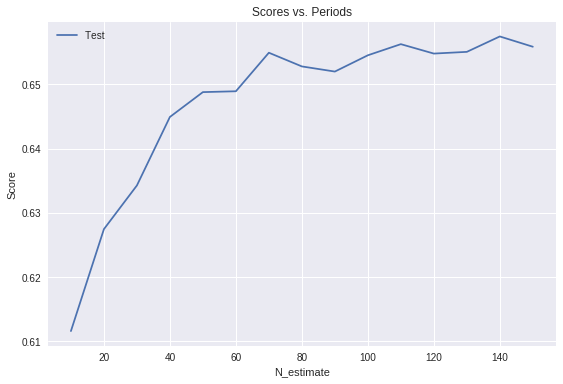

In [154]:
a=[]
b=[]
for i in range(15):
  a.append((i+1)*10)
  clf = RandomForestClassifier(n_estimators=(i+1)*10,  min_samples_split=2, random_state=0)
  print "n_estimate:",(i+1)*10
  scores = cross_val_score(clf, X, Y.ravel())
  b.append(scores.mean())  
print "Optimization Complete!"
A = np.array(a)
B = np.array(b)
plt.ylabel("Score")
plt.xlabel("N_estimate")
plt.title("Scores vs. Periods")
plt.tight_layout()
plt.plot(A,B, label="Test ")
plt.legend()

其次优化次要参数min_samples_split


In [158]:
clf = RandomForestClassifier(n_estimators=150,  min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, Y.ravel())
print scores.mean()

0.6558650298024048


min_samples_split: 10 socres= 0.6577320703784646
min_samples_split: 20 socres= 0.6543990030505071
min_samples_split: 30 socres= 0.659732710506567
min_samples_split: 40 socres= 0.6527987897598063
min_samples_split: 50 socres= 0.6605331906986439
min_samples_split: 60 socres= 0.66079793715167
min_samples_split: 70 socres= 0.6575990033491738
min_samples_split: 80 socres= 0.6563993233918918
min_samples_split: 90 socres= 0.6565321232638065
min_samples_split: 100 socres= 0.6549316432423963
Optimization Complete!


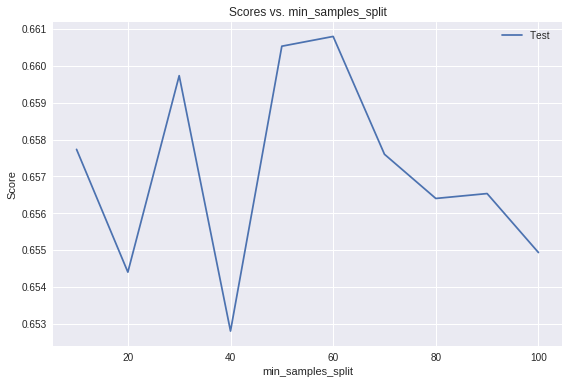

In [161]:
a=[]
b=[]
for i in range(10):
  a.append((i+1)*10)
  clf = RandomForestClassifier(n_estimators=150,  min_samples_split=(i+1)*10, random_state=0)
  scores = cross_val_score(clf, X, Y.ravel())
  b.append(scores.mean())  
  print "min_samples_split:",((i+1)*10), "socres=",scores.mean()
print "Optimization Complete!"
A = np.array(a)
B = np.array(b)
plt.ylabel("Score")
plt.xlabel("min_samples_split")
plt.title("Scores vs. min_samples_split")
plt.tight_layout()
plt.plot(A,B, label="Test ")
plt.legend()

当n_estimators =150时，min_samples_split=60，score有最大值**65.18%。**

In [113]:
clf = RandomForestClassifier(n_estimators=40,  min_samples_split=40, random_state=0)
scores = cross_val_score(clf, X, Y.ravel())
scores.mean()

0.6515998027733018

#决策树分类器
决策树算法借助于树的分支结构实现分类。树的内部结点表示对某个属性的判断，该结点的分支是对应的判断结果；叶子结点代表一个类标。


In [0]:
import io
from scipy import misc
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

代码使用scikit-learn自带的tree模块的DecisionTreeClassifier函数。


In [0]:
def build_decision_tree(X, y, depth=None):
    a=[]
    b=[]
    for i in range(15):
      dt = DecisionTreeClassifier(random_state=42, max_depth=i+1)
      a.append((i+1))
      print('max_depth:',i+1,'CV score:', cross_val_score(estimator=dt, X=X, y=y).mean())
      b.append(cross_val_score(estimator=dt, X=X, y=y).mean())
      dt.fit(X, y)
    A = np.array(a)
    B = np.array(b)
    plt.ylabel("CV Score")
    plt.xlabel("max_depth")
    plt.title("Scores vs. max_depth")
    plt.tight_layout()
    plt.plot(A,B, label="Train ")
    plt.legend()
    return dt

栅格化搜索决策树深度最优解。

Max_Depth=9, Accuracy=**59.68%**


('max_depth:', 1, 'CV score:', 0.5421308852689416)
('max_depth:', 2, 'CV score:', 0.5599994195625738)
('max_depth:', 3, 'CV score:', 0.5616013405442145)
('max_depth:', 4, 'CV score:', 0.5751997408852919)
('max_depth:', 5, 'CV score:', 0.5848001684053602)
('max_depth:', 6, 'CV score:', 0.5852000624213433)
('max_depth:', 7, 'CV score:', 0.5942671567787451)
('max_depth:', 8, 'CV score:', 0.5938675305601383)
('max_depth:', 9, 'CV score:', 0.5968017710082834)
('max_depth:', 10, 'CV score:', 0.59306710419207)
('max_depth:', 11, 'CV score:', 0.5934661441919165)
('max_depth:', 12, 'CV score:', 0.5826659294932154)
('max_depth:', 13, 'CV score:', 0.5838669428053774)
('max_depth:', 14, 'CV score:', 0.5789336623147193)
('max_depth:', 15, 'CV score:', 0.5728002216320354)


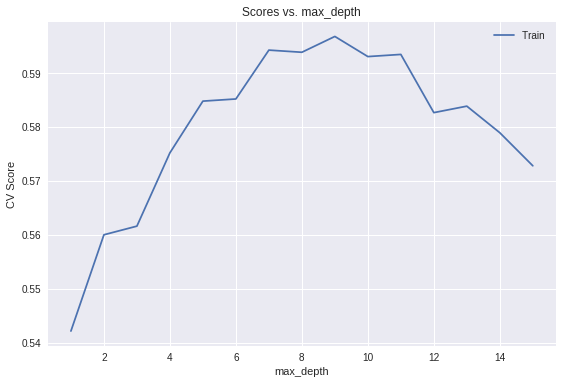

In [152]:
dt = build_decision_tree(X=X, y=Y, depth=8)

#神经网络训练

使用神经网络作为分类器

3层隐藏层，每个隐藏层20个节点，输入为56features，输出2类。

learning_rate = 0.001 
training_epochs = 300 
batch_size = 4000时，
最优情况下**有59.32%的准确率**

但极易发生过拟合现象




In [0]:
# Parameters# Param 
learning_rate = 0.001
training_epochs = 200
batch_size = 4000
display_step = 5


# Network Parameters
n_hidden_1 = 20 # 1st layer number of features
n_hidden_2 = 20 # 2nd layer number of features
n_hidden_3 = 20
n_input = 56 # Number of feature
n_classes = 2 # Number of classes to predict


# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

Epoch: 0005 cost= 16134.125000000
Accuracy: 0.502
Epoch: 0010 cost= 14248.662109375
Accuracy: 0.5048
Epoch: 0015 cost= 12649.745117188
Accuracy: 0.5164
Epoch: 0020 cost= 11240.320312500
Accuracy: 0.5108
Epoch: 0025 cost= 10070.316406250
Accuracy: 0.5176
Epoch: 0030 cost= 9107.396484375
Accuracy: 0.5284
Epoch: 0035 cost= 8288.601562500
Accuracy: 0.5336
Epoch: 0040 cost= 7620.580566406
Accuracy: 0.5428
Epoch: 0045 cost= 7049.237792969
Accuracy: 0.5472
Epoch: 0050 cost= 6562.976074219
Accuracy: 0.5528
Epoch: 0055 cost= 6137.803222656
Accuracy: 0.5556
Epoch: 0060 cost= 5750.921386719
Accuracy: 0.5624
Epoch: 0065 cost= 5398.643554688
Accuracy: 0.5664
Epoch: 0070 cost= 5076.773437500
Accuracy: 0.5672
Epoch: 0075 cost= 4778.326171875
Accuracy: 0.57
Epoch: 0080 cost= 4503.961425781
Accuracy: 0.574
Epoch: 0085 cost= 4252.691406250
Accuracy: 0.5744
Epoch: 0090 cost= 4024.011474609
Accuracy: 0.5768
Epoch: 0095 cost= 3818.063232422
Accuracy: 0.5828
Epoch: 0100 cost= 3635.179687500
Accuracy: 0.584


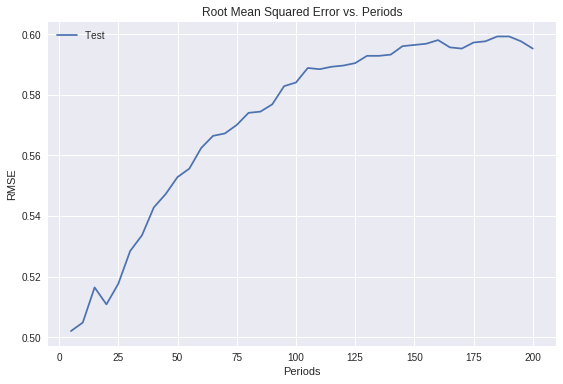

In [174]:
# Launch the graph
a = []
b = []
c1 = []
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X)/batch_size)
        X_batches = np.array_split(X, total_batch)
        Y_batches = np.array_split(Y, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == display_step-1:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)
            a.append(epoch+1)
            #b.append(avg_cost)
            # Test model
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print "Accuracy:", accuracy.eval({x: X_test, y: Y_test})
            b.append(accuracy.eval({x: X_test, y: Y_test}))
    #end for
    print("Optimization Finished!")
      # Output a graph of loss metrics over periods.
    A = np.array(a)
    B = np.array(b)
    C = np.array(c1)
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(A,B, label="Test ")
    #plt.plot(A,C, label="Accuracy")
    plt.legend()

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: X_test, y: Y_test}))
    global result 
    result = tf.argmax(pred, 1).eval({x: X_test, y: Y_test})